# Applying GIRAFFE on in silico data

In this notebook, we aim to investigate the performance of GIRAFFE on two artificial datasets. These datasets are designed to be representative of the underlying biology, and show that GIRAFFE performs well under those assumptions. We will use PANDA [1], OTTER [2], and the motif as comparisons. 

## 1. Load required packages

We load GIRAFFE and other required packages. PANDA and OTTER are available on netZooPy. Feel free to check [here](https://netzoopy.readthedocs.io/en/latest/install/index.html) for more information about installing netZooPy. 

In [1]:
import giraffe
import matplotlib.pyplot as plt
import networkx as nx
from netZooPy.otter.otter import otter
from netZooPy.panda.panda import Panda 
import numpy as np
from numpy.random import default_rng
import pandas as pd
import random
import scipy
from scipy import stats

## 2. Recovering ground-truth from model satisfying our assumptions

In TODO we present GIRAFFE and its underlying assumptions. Here we create a toy dataset to show that GIRAFFE performs well under those assumptions. We need to generate the true regulation matrix R, the transcription factor activity matrix TFA, the PPI network, the gene expression, and the motif. The number of genes, transcription factors, and samples are picked to be coherent with the typical biological setting. 

In [2]:
TF = 100  # Number of transcription factors
G = 500  # Number of genes
n = 50  # Number of samples

We start with the PPI network, an undirected graph where the degree of each edge is sampled according to the distribution observed on real data. 

In [3]:
def generate_ppi(tf):
    sample_ppi = pd.read_csv('sample_data/PPI.csv') #  PPI from human data
    degree = nx.degree_histogram(nx.from_numpy_matrix(sample_ppi.to_numpy()))
    degree_prob = [d / np.sum(degree) for d in degree] #  Degree distribution for each node
    
    #  Sample degrees for each node according to distribution observed in real data
    D = random.choices(population = [i for i in range(len(degree_prob))], weights = degree_prob, k = tf)
    G = nx.expected_degree_graph(D) 
    PPI = nx.to_numpy_array(G) #  Create undirected PPI network
    np.fill_diagonal(PPI, 1) #  By definition, transcription factors interact with themselves
    giraffe.utils.check_symmetric(PPI) #  Sanity check
    return PPI

We assume that transcription factors form a protein complex if they form a clique in the PPI. The next piece of code return the cliques, i.e. the protein complexes, for every transcription factor. 

In [4]:
def find_cliques(ppi) :
    """
    Returns a maps from a transcription factor to the id of the cliques it belongs to
    """
    G = nx.from_numpy_array(ppi)
    cliques = {}
    idx = 0
    for i in nx.find_cliques(G):
        if len(i) > 1:
            for protein in i:
                if protein in cliques.keys():
                    cliques[protein] = cliques[protein] + [idx]
                else:
                    cliques[protein] = [idx]
            idx += 1
    # idx: number of cliques in ppi
    # map from transcription factor to its cliques (cliques of size 1 are neglected)
    return idx, cliques

At this point we are ready to generate the TFA matrix. For each protein complex we generate its activity. The row corresponding to a given transcription factor is the sum of the quantity of its protein complexes.If a transcription factor is not part of a protein complex, we assume that it regulates genes independently from the others. 

In [5]:
def generate_tfa(ppi, n):
    tf = ppi.shape[0]
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_quantity = np.zeros((n, cliques_no)) #  quantity for each protein complex
    
    #  Generate quantity for each complex
    for i in range(cliques_no) :
        A = np.random.uniform(-1, 1, n)
        cliques_quantity[:, i] = A
    
    # The quantity for each tf is the sum of the cliques it belongs to
    TFA = np.zeros((tf, n))
    for k, v in cliques.items() :
        TFA[k, :] = np.sum(cliques_quantity[:, [v]])
    
    # If a transcription factor is not part of a complex, it can still be active
    for i in range(tf) :
        if np.sum(TFA[i, :]) == 0 :
            TFA[i, :] = np.random.uniform(-1, 1, n)
            
    return TFA #  Generated matrix

The mechanism to generate the true regulation matrix (which serves as ground-truth to estimate the performance) is similar: each protein complex (i.e. each clique in the PPI) has a sparse regulation vector describing its relationship with the target genes. Hence, for for each column in R, we sum the generated regulation vectors for each protein complex the transcription factor belongs to. If a transcription factor is not part of any complex, it can still regulate genes independently. 

In [6]:
def generate_regulation(g, tf, ppi) :
    sparsity = 0.5
    rng = default_rng()
    rvs = stats.uniform(loc = -1, scale = 2).rvs
    
    R = np.zeros((g, tf)) #  To store the ground-truth regulation matrix
    
    cliques_no, cliques = find_cliques(ppi) #  number of cliques and map tf -> cliques_id
    cliques_to_regulation = np.zeros((g, cliques_no)) #  How much each clique regulates the genes
    
    for i in range(cliques_no) :
        regulation = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A
        cliques_to_regulation[:, i] = regulation.flatten()
    
    for k, v in cliques.items() :
        R[:, k] = np.sum(cliques_to_regulation[:, [v]])
    
    #  If a transcription factor is not part of any clique, it can still regulate gene expression 
    for i in range(tf) :
        if np.sum(R[:, i]) == 0 :
            R[:, i] = scipy.sparse.random(g, 1, sparsity, random_state = rng, data_rvs = rvs).A.flatten()
            
    return R #  Generated matrix

We generate a binary motif as follows. First, we map each non-zero entry of R to one, resulting in a binary matrix. Then we we flip a certain number of entries, such that a zero (i.e. no regulation) becomes a one (i.e. regulation) and viceversa. The ratio of flipped bits is passed as the parameter shuffle to the function. 

In [7]:
def generate_motif(R, shuffle = 0.2):
    motif = R.copy()
    motif[motif != 0] = 1
    to_shuffle = int(motif.shape[0] * motif.shape[1] * shuffle)
    for i in range(to_shuffle) :
        x = np.random.randint(0, R.shape[0])
        y = np.random.randint(0, R.shape[1])
        if motif[x, y] == 1 :
            motif[x, y] = 0
        else :
            motif[x, y] = 1
    return motif

The expression matrix is generated as the product of the ground-truth matrices R and TFA. This is coherent with our underlying assumption that gene expression can be factorized as this product. 

In [8]:
def compute_expression(R, TFA) :
    return R.dot(np.abs(TFA)) 

Now we have all the required data for our simulation. We generated both the input to estimate the parameters of our model (gene expression, the PPI, and the motif), and the ground-truth to measure its performance(the regulation and transcription factor activity matrix). 

In [10]:
def simulation(n = 50, shuffling = 0.2):
    tf = 100
    g = 500

    ppi = generate_ppi(tf)
    TFA = generate_tfa(ppi, n)
    R = generate_regulation(g, tf, ppi)
    gene_expression = compute_expression(R, TFA)
    motif = generate_motif(R, shuffling)
    
    R_giraffe = giraffe.Giraffe(gene_expression, motif, ppi, lr = 0.0001).get_regulation()
    R_otter = otter(motif.T, ppi, np.corrcoef(gene_expression), Iter = 200).T
    R_panda = giraffe.compute_panda_locally(gene_expression, motif, ppi)
    print(R_panda)
    return giraffe.plot_auroc(R, [R_giraffe, R_otter, R_panda, motif], ["GIRAFFE", "OTTER", "PANDA", "Motif"], title = "AUROC, reliability of the motif = " + str(1 - shuffling))

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    560.959665  559.490212  561.299586  557.086343  562.564778  561.875791   
1    560.020783  561.135049  559.918551  560.397967  559.751910  560.255347   
2    559.304261  559.464270  560.053221  559.571435  560.111805  557.679229   
3    563.060375  561.815595  560.997305  558.953769  562.476915  558.816461   
4    558.695939  558.868110  560.141209  558.829364  559.805413  559.879831   
..          ...         ...         ...         ...         ...         ...   
495  562.547726  563.253956  562.528258  559.350701  560.551763  562.618963   
496  561.853694  560.764579  561.255795  561.275544  559.903117  

step: 126, hamming: 821332.9588887634
step: 127, hamming: 672643.325039373
step: 128, hamming: 550841.528336157
step: 129, hamming: 451075.45586152
step: 130, hamming: 369365.2418782762
step: 131, hamming: 302447.5762230261
step: 132, hamming: 247647.44611986697
step: 133, hamming: 202772.57279593835
step: 134, hamming: 166026.63518688828
step: 135, hamming: 135937.97671377283
step: 136, hamming: 111301.08367498264
step: 137, hamming: 91128.53212615095
step: 138, hamming: 74611.61769649926
step: 139, hamming: 61088.0413580206
step: 140, hamming: 50015.437407532896
step: 141, hamming: 40949.67286769438
step: 142, hamming: 33527.06971163558
step: 143, hamming: 27449.838606752593
step: 144, hamming: 22474.14732752696
step: 145, hamming: 18400.348548154954
step: 146, hamming: 15064.97439210373
step: 147, hamming: 12334.182656029458
step: 148, hamming: 10098.38777297501
step: 149, hamming: 8267.867384552239
step: 150, hamming: 6769.1602298206935
step: 151, hamming: 5542.120291010815
step: 1

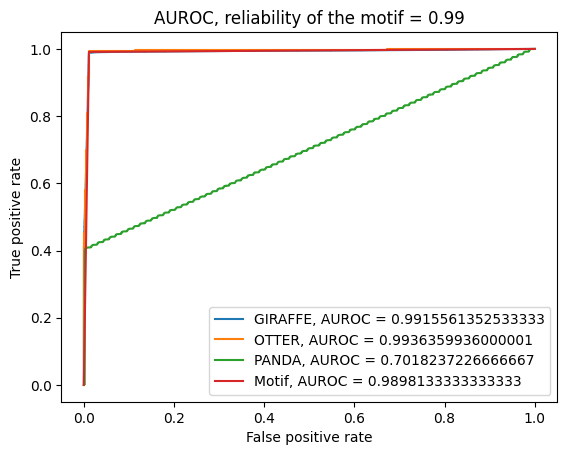

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    560.081912  558.902286  559.507438  560.288993  557.869002  560.579653   
1    561.415561  559.422529  558.904587  560.234458  559.546583  559.242513   
2    559.108353  557.307317  559.113994  557.349262  558.619352  557.798034   
3    561.099739  559.975600  558.802552  559.290160  559.714154  560.106739   
4    563.523101  562.167366  562.509477  560.664674  561.974776  562.583306   
..          ...         ...         ...         ...         ...         ...   
495  563.219252  562.769804  563.088468  560.923258  562.492356  562.739556   
496  564.965802  561.933810  562.559230  562.041596  562.853871  

step: 122, hamming: 3048449.484534512
step: 123, hamming: 2537180.8931314745
step: 124, hamming: 2104506.5532833687
step: 125, hamming: 1740999.6262711594
step: 126, hamming: 1437287.7068548982
step: 127, hamming: 1184610.8802994364
step: 128, hamming: 975083.4979245389
step: 129, hamming: 801784.0127494656
step: 130, hamming: 658737.3234785727
step: 131, hamming: 540851.1082807719
step: 132, hamming: 443823.5061690112
step: 133, hamming: 364044.8737655893
step: 134, hamming: 298502.3645587434
step: 135, hamming: 244690.62772470753
step: 136, hamming: 200533.60425497624
step: 137, hamming: 164314.6424474493
step: 138, hamming: 134616.89942186556
step: 139, hamming: 110273.05973794998
step: 140, hamming: 90322.55109850861
step: 141, hamming: 73975.43660523211
step: 142, hamming: 60582.90729839004
step: 143, hamming: 49612.31513003243
step: 144, hamming: 40626.55017057939
step: 145, hamming: 33267.11446792866
step: 146, hamming: 27240.051721067375
step: 147, hamming: 22304.391962482183
s

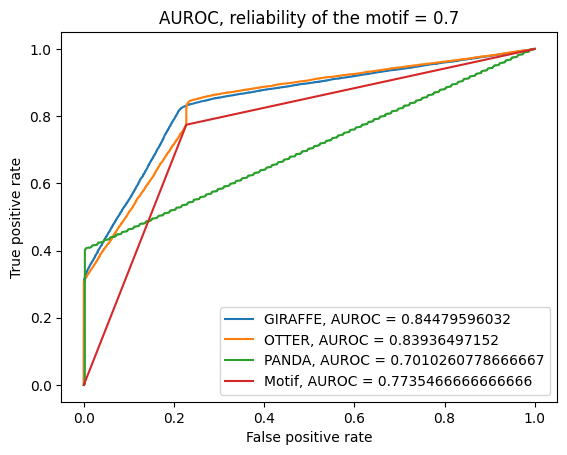

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    562.066458  561.293394  560.444457  560.100056  560.865030  562.119922   
1    560.110716  562.559480  559.013223  562.298846  562.119923  560.865540   
2    557.964238  559.542599  558.220264  560.684621  558.550159  558.134382   
3    563.011279  563.903247  563.987769  563.421220  563.436629  563.269781   
4    561.628048  558.266614  562.452263  560.557484  557.779698  561.119279   
..          ...         ...         ...         ...         ...         ...   
495  558.685744  560.352587  561.105214  562.837588  560.248159  560.584356   
496  561.602521  560.344142  559.455338  561.779068  561.078165  

step: 123, hamming: 116.66997686132432
step: 124, hamming: 95.52258321433258
step: 125, hamming: 78.20821385677719
step: 126, hamming: 64.03216230990982
step: 127, hamming: 52.42561388562393
step: 128, hamming: 42.92284163483429
step: 129, hamming: 35.14252951941681
step: 130, hamming: 28.772473814441682
step: 131, hamming: 23.557058489559175
step: 132, hamming: 19.28699751815033
step: 133, hamming: 15.7909400623703
step: 134, hamming: 12.92859188710022
step: 135, hamming: 10.585081494174958
step: 136, hamming: 8.666361652236938
step: 137, hamming: 7.095436398887634
step: 138, hamming: 5.809273721981048
step: 139, hamming: 4.756245885700226
step: 140, hamming: 3.894095484741211
step: 141, hamming: 3.188222317298889
step: 142, hamming: 2.610301838279724
step: 143, hamming: 2.1371357045021058
step: 144, hamming: 1.7497421362991332
step: 145, hamming: 1.4325720770187378
step: 146, hamming: 1.1728915913658142
step: 147, hamming: 0.9602807961654664
step: 148, hamming: 0.7862148237609863
ste

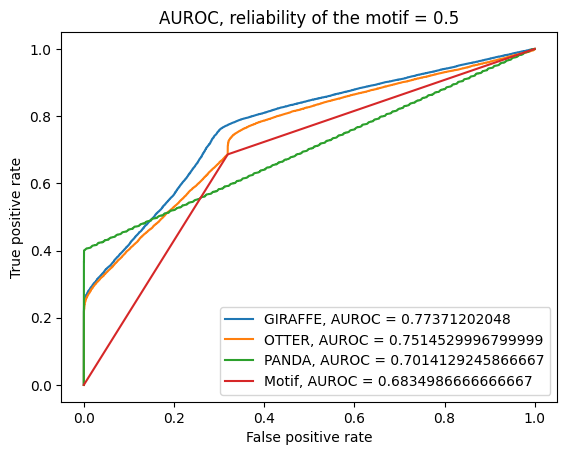

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    562.316695  563.085376  563.701927  561.302085  561.366992  563.877301   
1    558.279728  558.187723  556.550531  561.170528  559.392572  558.956400   
2    562.746975  562.011270  560.885883  561.180696  562.356458  561.354601   
3    556.957135  557.458348  558.617138  559.447202  558.591935  558.671862   
4    557.512451  556.542376  558.543199  559.061104  558.598746  559.501827   
..          ...         ...         ...         ...         ...         ...   
495  564.413049  564.297773  564.028310  563.915215  562.700395  561.552264   
496  559.426897  557.940216  560.374113  559.048971  558.104368  

step: 120, hamming: 23151.2914704716
step: 121, hamming: 18957.093487437414
step: 122, hamming: 15522.358515590868
step: 123, hamming: 12709.693222846357
step: 124, hamming: 10406.517904421169
step: 125, hamming: 8520.598912165764
step: 126, hamming: 6976.381119258005
step: 127, hamming: 5711.9780725548335
step: 128, hamming: 4676.703458665807
step: 129, hamming: 3829.0468348682743
step: 130, hamming: 3135.0143840609235
step: 131, hamming: 2566.7690462900678
step: 132, hamming: 2101.516266311708
step: 133, hamming: 1720.591120274388
step: 134, hamming: 1408.7105391699038
step: 135, hamming: 1153.360781973949
step: 136, hamming: 944.2958030982103
step: 137, hamming: 773.126415584599
step: 138, hamming: 632.9838443833418
step: 139, hamming: 518.2442248302093
step: 140, hamming: 424.30300309820365
step: 141, hamming: 347.39020938338115
step: 142, hamming: 284.4192037394855
step: 143, hamming: 232.86282293812297
step: 144, hamming: 190.65198232877563
step: 145, hamming: 156.09264297614956


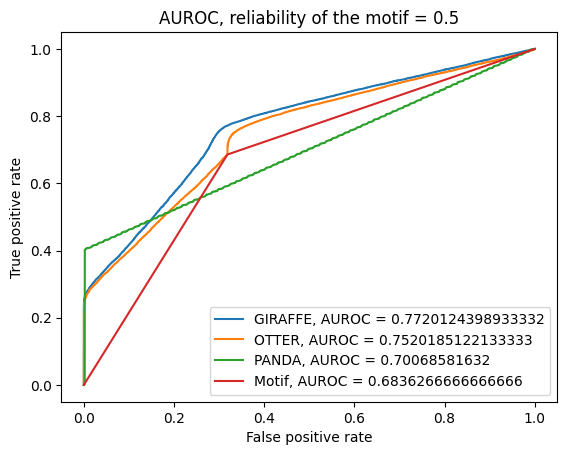

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    562.354926  562.692280  559.989638  562.654780  564.948291  561.791613   
1    560.921211  562.347294  562.500746  561.379849  562.225389  561.003253   
2    562.324167  562.933074  562.970793  563.313424  560.862487  563.486502   
3    557.338440  558.693000  558.396284  560.714609  557.884276  561.310291   
4    557.023875  557.134979  559.440533  558.365315  558.276359  560.271428   
..          ...         ...         ...         ...         ...         ...   
495  562.212088  559.634236  560.868883  560.838465  560.411207  560.754715   
496  561.930231  561.267338  561.689361  563.675578  561.132796  

step: 120, hamming: 321678.6600519678
step: 121, hamming: 264903.59556003666
step: 122, hamming: 217903.14735652533
step: 123, hamming: 179080.13543699586
step: 124, hamming: 147067.6210032689
step: 125, hamming: 120707.3854583866
step: 126, hamming: 99025.41729086348
step: 127, hamming: 81207.23302777186
step: 128, hamming: 66574.73046501256
step: 129, hamming: 54565.219614099195
step: 130, hamming: 44713.09508548291
step: 131, hamming: 36633.82989153776
step: 132, hamming: 30010.41507499539
step: 133, hamming: 24581.858544743056
step: 134, hamming: 20133.49618371302
step: 135, hamming: 16488.93260198765
step: 136, hamming: 13503.322157384186
step: 137, hamming: 11057.786119577395
step: 138, hamming: 9054.803932320812
step: 139, hamming: 7414.406041356708
step: 140, hamming: 6071.034751745212
step: 141, hamming: 4970.958449258285
step: 142, hamming: 4070.1493788729163
step: 143, hamming: 3332.534654492941
step: 144, hamming: 2728.5646897933425
step: 145, hamming: 2234.0354366346987
st

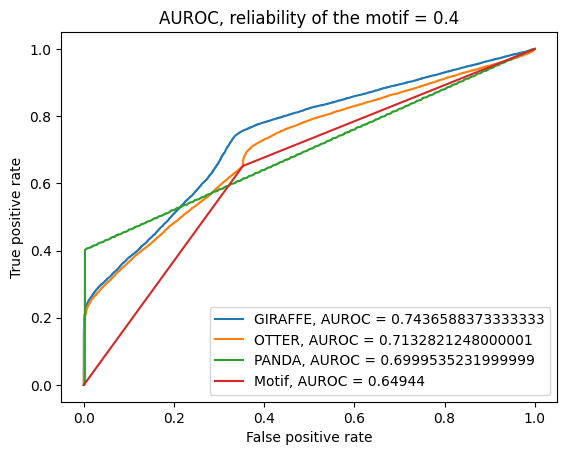

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    560.088878  559.756992  561.302821  559.374153  559.979110  560.961891   
1    558.106053  558.505889  560.123642  558.916568  561.090068  559.423194   
2    558.629766  560.109069  560.691247  560.319211  560.649545  562.484122   
3    562.806183  563.572181  562.197330  560.704999  561.467746  561.148755   
4    556.191320  557.400855  556.305102  558.649908  558.291368  558.308291   
..          ...         ...         ...         ...         ...         ...   
495  562.513424  562.201882  561.842872  562.724654  562.729847  561.819056   
496  559.644091  559.981132  559.046227  561.888525  561.392875  

step: 130, hamming: 2714.8126184179155
step: 131, hamming: 2222.740865606807
step: 132, hamming: 1819.8524197671313
step: 133, hamming: 1489.9859838451061
step: 134, hamming: 1219.9081507907765
step: 135, hamming: 998.7832050502152
step: 136, hamming: 817.738879937943
step: 137, hamming: 669.5106919161612
step: 138, hamming: 548.1506752303729
step: 139, hamming: 448.78883739304445
step: 140, hamming: 367.4378308413162
step: 141, hamming: 300.83300333529616
step: 142, hamming: 246.30142444144607
step: 143, hamming: 201.65464909146428
step: 144, hamming: 165.1009056021409
step: 145, hamming: 135.17320071029545
step: 146, hamming: 110.67045198055291
step: 147, hamming: 90.6092902287352
step: 148, hamming: 74.1845972293408
step: 149, hamming: 60.737196446159366
step: 150, hamming: 49.727397076848746
step: 151, hamming: 40.71333791551685
step: 152, hamming: 33.3332520333736
step: 153, hamming: 27.290950044401406
step: 154, hamming: 22.34393309853864
step: 155, hamming: 18.293659296870707
st

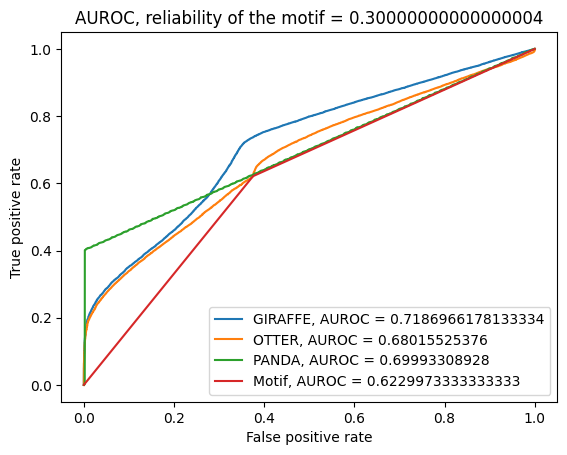

Loading motif data ...
  Elapsed time: 0.01 sec.
Loading PPI data ...
Number of PPIs: 200
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.03 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt              0           1           2           3           4           5   \
0    561.976644  561.168871  561.782769  561.797780  562.319800  562.636149   
1    559.269451  559.427221  558.062869  560.418345  556.876045  557.333417   
2    563.886502  564.156943  563.125944  562.326952  562.481218  562.607672   
3    561.655838  561.081968  561.053340  559.443829  560.226972  559.761544   
4    560.822977  560.613628  559.685329  561.567210  559.669357  560.306433   
..          ...         ...         ...         ...         ...         ...   
495  559.738912  559.530690  560.626358  558.994836  558.723495  559.138310   
496  559.670827  561.070176  559.572948  558.763387  559.246437  

step: 120, hamming: 10887.402182671814
step: 121, hamming: 8918.190500565228
step: 122, hamming: 7304.480477842446
step: 123, hamming: 5982.317624307492
step: 124, hamming: 4899.177966923547
step: 125, hamming: 4011.949866831129
step: 126, hamming: 3285.264389358
step: 127, hamming: 2690.115760430745
step: 128, hamming: 2202.723996212854
step: 129, hamming: 1803.5983988569476
step: 130, hamming: 1476.7670719916375
step: 131, hamming: 1209.1439524711545
step: 132, hamming: 990.0087427112779
step: 133, hamming: 810.5802481551275
step: 134, hamming: 663.6662619072823
step: 135, hamming: 543.376481688442
step: 136, hamming: 444.88709831686975
step: 137, hamming: 364.24792208294286
step: 138, hamming: 298.22427179132484
step: 139, hamming: 244.1674661118736
step: 140, hamming: 199.9087175420662
step: 141, hamming: 163.67222089705814
step: 142, hamming: 134.00397064344716
step: 143, hamming: 109.71346312947283
step: 144, hamming: 89.82595415025273
step: 145, hamming: 73.54336310488557
step: 

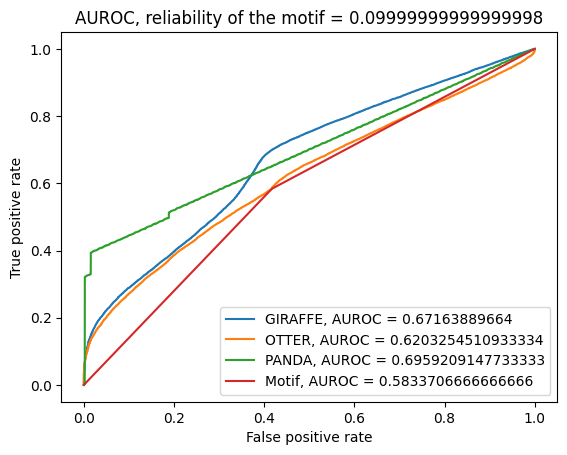

In [12]:
shuffling = [0.01, 0.3, 0.5, 0.5, 0.6, 0.7, 0.9]

scores = []
for shuffle in shuffling :
    scores.append(simulation(shuffling = shuffle))
    
giraffe.utils.star_plot(list(map(list, zip(*scores))), [str(round(1 - shuffle, 2)) for shuffle in shuffling], ["GIRAFFE", "OTTER", "PANDA", "Motif"])

We observe how GIRAFFE is the best method across multiple noise setting. Moreover it is the most robust one: PANDA outperforms it in the case where the motif is non-reliable, but it performs significantly worse in the case the motif is reliable. OTTER has similar performance for a reliable motif, but it gets worse as the motif gradually becomes more corrupted. 

## 3. Recovering ground-truth from projections

We create a new toy dataset. The dimensionality are picked to be coherent with the typical biological setting. 

In [13]:
TF = 100  # Number of transcription factors
G = 500  # Number of genes
n = 50  # Number of samples

Similarly as before, we need to simulate the ground-truth regulation matrix R. We generate a sparse matrix, where non-zero entries are uniformly sampled in (0, 1). 

In [14]:
def generate_regulation(g, tf) :
    sparsity = 0.2
    rng = default_rng()
    rvs = stats.uniform(loc = 0, scale = 1).rvs
    R = scipy.sparse.random(g, tf, sparsity, random_state = rng, data_rvs = rvs).A
    return R

The motif is computed from the true regulation matrix by corrupting it with random uniform noise. 

In [15]:
def generate_motif(r):
    return r + np.random.uniform(-1, 1, (r.shape[0], r.shape[1]))

We decide that two proteins interact if they co-regulate "many" genes. To pick a proper threshold value, we plot the distribution of the number of co-regulated genes. 

(0.0, 450.0)

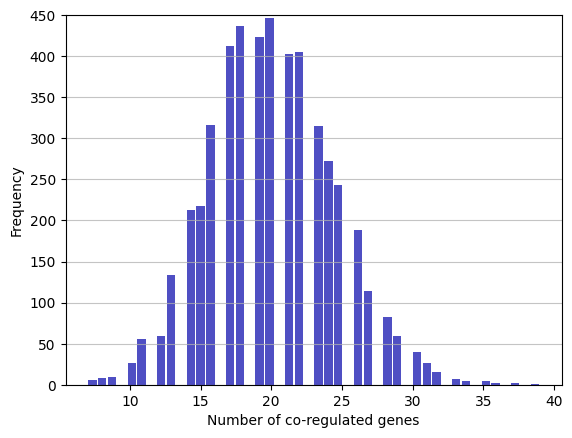

In [16]:
R = generate_regulation(G, TF)

cooperation = []
R[R != 0] = 1
for i in range(TF):
    for j in range(i + 1, TF):
        cooperation.append(R[:, i].dot(R[:, j]))

"The following lines or code are taken from https://realpython.com/python-histograms/ [Accessed on Jan. 13th 2023]"
s, bins, patches = plt.hist(x = cooperation, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha = 0.75)
plt.xlabel('Number of co-regulated genes')
plt.ylabel('Frequency')
maxfreq = s.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

We want a sparse PPI, so we heuristically pick 25 as threshold value (larger than the mean, but small enough to recover enough information). We now construct the PPI network. 

In [17]:
def generate_ppi(R):
    ppi = np.zeros((R.shape[1], R.shape[1]))
    R[R != 0] = 1
    for i in range(R.shape[1]):
        for j in range(R.shape[1]):
            if i == j :
                ppi[i, j] = 1 # By definition
            else :
                if R[:, i].dot(R[:, j]) >= 25:
                    ppi[i, j] = 1
    return ppi

Gene expressioned is sampled from a multi-normal distribution with mean zero and the same covariance as the regulation matrix. 

In [18]:
def generate_expression(C) :
    return np.random.multivariate_normal([0 for i in range(G)], C.T, n).T

Now we have generators for all required data: a ground-truth regulation matrix, a corrupter motif, and a PPI netork. We are ready to put the pieces together in our simulation. 

In [19]:
def simulation() :
    R = generate_regulation(G, TF)
    ppi = generate_ppi(R)
    motif = generate_motif(R)
    expression = generate_expression(R.dot(R.T))

    otter_regulation = otter(motif.T, ppi, np.corrcoef(motif))
    giraffe_oracle_regulation = giraffe.Giraffe(expression, motif, ppi, lam = [0.000001, 5, 50, 1, 1]).get_regulation()
    giraffe_agnostic_regulation = giraffe.Giraffe(expression, motif, ppi).get_regulation()
    motif[motif >= np.quantile(motif, .6)] = 1 # PANDA requires a binary motif
    motif[motif != 1] = 0
    panda_regulation = giraffe.utils.compute_panda_locally(expression, motif, ppi)
    giraffe.utils.plot_auroc(
        R, 
        [otter_regulation.T, giraffe_oracle_regulation, giraffe_agnostic_regulation,panda_regulation, motif], 
        ["OTTER", "GIRAFFE (custom weights)", "GIRAFFE (learned weights)", "PANDA", "Motif"]
    )

Loading motif data ...
  Elapsed time: 0.00 sec.
Loading PPI data ...
Number of PPIs: 1678
  Elapsed time: 0.00 sec.
Calculating coexpression network ...
  Elapsed time: 0.00 sec.
Creating motif network ...
  Elapsed time: 0.02 sec.
Creating PPI network ...
  Elapsed time: 0.00 sec.
union tmp/motif.txt            0         1         2         3         4         5          6   \
0   -3.160907 -3.258211 -3.385997 -3.937827  0.136165 -3.362806  -2.391703   
1   -5.413494 -4.932296 -1.290181 -6.859105  2.575752  1.243045  -5.931305   
2   -4.158749  0.490173 -4.607153  0.227240  4.908601  1.159401   5.575238   
3   -7.407340 -4.225042 -1.583153 -1.927300 -2.596822 -0.758797 -11.092893   
4    0.671996 -3.995378 -0.650545 -2.725782  1.376172  6.133711  -2.916028   
..        ...       ...       ...       ...       ...       ...        ...   
495 -7.867784 -2.938528 -3.763845 -7.143398  2.350710  2.781607   0.892584   
496 -7.353722  1.085534  0.523706 -1.581398 -5.327272  2.717806  -9.9368

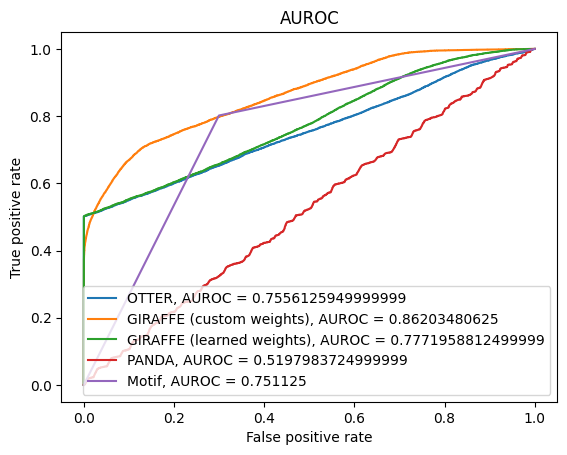

In [20]:
simulation()

We observe that GIRAFFE performs better than the other baselines. Note how GIRAFFE optionally accepts custom weights: this can be tuned (using proper statistical practices) and guide the optimization algorithm to focus on the reconstruction loss, the coherence with the PPI, or the coherence with the co-expression network. If no custom weights are provided, GIRAFFE assigns weights internally using a multi-task learning algorithm [3]. 

## References

[1] Glass K, Huttenhower C, Quackenbush J, Yuan GC. "Passing Messages Between Biological Networks to Refine Predicted Interactions", PLoS One, 2013 May 31;8(5):e64832

[2] Weighill, Deborah, et al. "Gene regulatory network inference as relaxed graph matching." Proceedings of the... AAAI Conference on Artificial Intelligence. AAAI Conference on Artificial Intelligence. Vol. 35. No. 11. NIH Public Access, 2021.

[3] Lee J.H, Kim C. S. Multi-loss rebalancing algorithm for monocular depth estimation. In European Conference on Computer Vision, pages 785–801. Springer, 2020.